In [6]:
!pip install faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from faker import Faker
import random
import csv

# Crear un objeto Faker
fake = Faker()

# Definir el número de días del año
num_days = 365

# Definir el número de muestras por día (mañana, medio día, noche)
num_samples = 3

# Definir los nombres de las columnas del conjunto de datos
field_names = ['fecha', 'hora', 'temperatura', 'humedad', 'presion', 'condiciones_climaticas']

# Crear el archivo CSV para almacenar los datos generados
with open('clima_sintetico.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=field_names)

    # Escribir los nombres de las columnas en el archivo CSV
    writer.writeheader()

    # Generar los datos del clima sintético para un año
    for day in range(num_days):
        for sample in range(num_samples):
            # Generar la fecha y la hora
            date_time = fake.date_time_between(start_date='-1y', end_date='now')
            fecha = date_time.date()
            hora = date_time.strftime("%H:%M:%S")

            # Generar las variables de entrada aleatorias
            temperatura = round(random.uniform(10, 30), 2)
            humedad = round(random.uniform(0, 100), 2)
            presion = round(random.uniform(900, 1100), 2)

            # Generar las condiciones climáticas aleatorias basadas en las variables de entrada
            if temperatura >= 25 and humedad >= 80:
                condiciones_climaticas = 'soleado y húmedo'
            elif temperatura >= 20 and humedad <= 60:
                condiciones_climaticas = 'parcialmente nublado'
            elif temperatura <= 15:
                condiciones_climaticas = 'lluvioso'
            else:
                condiciones_climaticas = 'despejado'

            # Escribir los datos generados en el archivo CSV
            writer.writerow({'fecha': fecha, 'hora': hora, 'temperatura': temperatura, 'humedad': humedad, 'presion': presion, 'condiciones_climaticas': condiciones_climaticas})


In [9]:
import pandas as pd
import numpy as np

# Cargar el conjunto de datos sintético generado
df = pd.read_csv('clima_sintetico.csv')

# Convertir la columna de fecha y hora en un objeto datetime
df['fecha_hora'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'])

# Seleccionar las columnas relevantes para el modelo de predicción
df = df[['fecha_hora', 'temperatura', 'humedad', 'presion', 'condiciones_climaticas']]

# Establecer la columna de fecha y hora como el índice del DataFrame
df = df.set_index('fecha_hora')

# Dividir el conjunto de datos en conjuntos de entrenamiento, validación y prueba
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# Normalizar los datos
mean = train_df.mean()
std = train_df.std()
train_df = (train_df - mean) / std
val_df = (val_df - mean) / std
test_df = (test_df - mean) / std

# Convertir los conjuntos de datos en matrices NumPy
train_data = train_df.values
val_data = val_df.values
test_data = test_df.values


<ipython-input-9-ef2785f5dfc4>:26: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = train_df.mean()
<ipython-input-9-ef2785f5dfc4>:27: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std = train_df.std()


In [22]:
df.head()

,temperatura,humedad,presion,condiciones_climaticas
fecha_hora,,,,
2022-09-05 03:13:22,16.70,27.55,1004.61,despejado
2022-10-14 06:18:59,17.31,94.46,997.31,despejado
2022-08-13 12:43:53,18.30,21.64,1042.30,despejado
2022-11-14 15:51:08,25.63,90.00,908.56,soleado y húmedo
2022-12-13 07:11:56,27.30,5.93,1070.92,parcialmente nublado


In [23]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


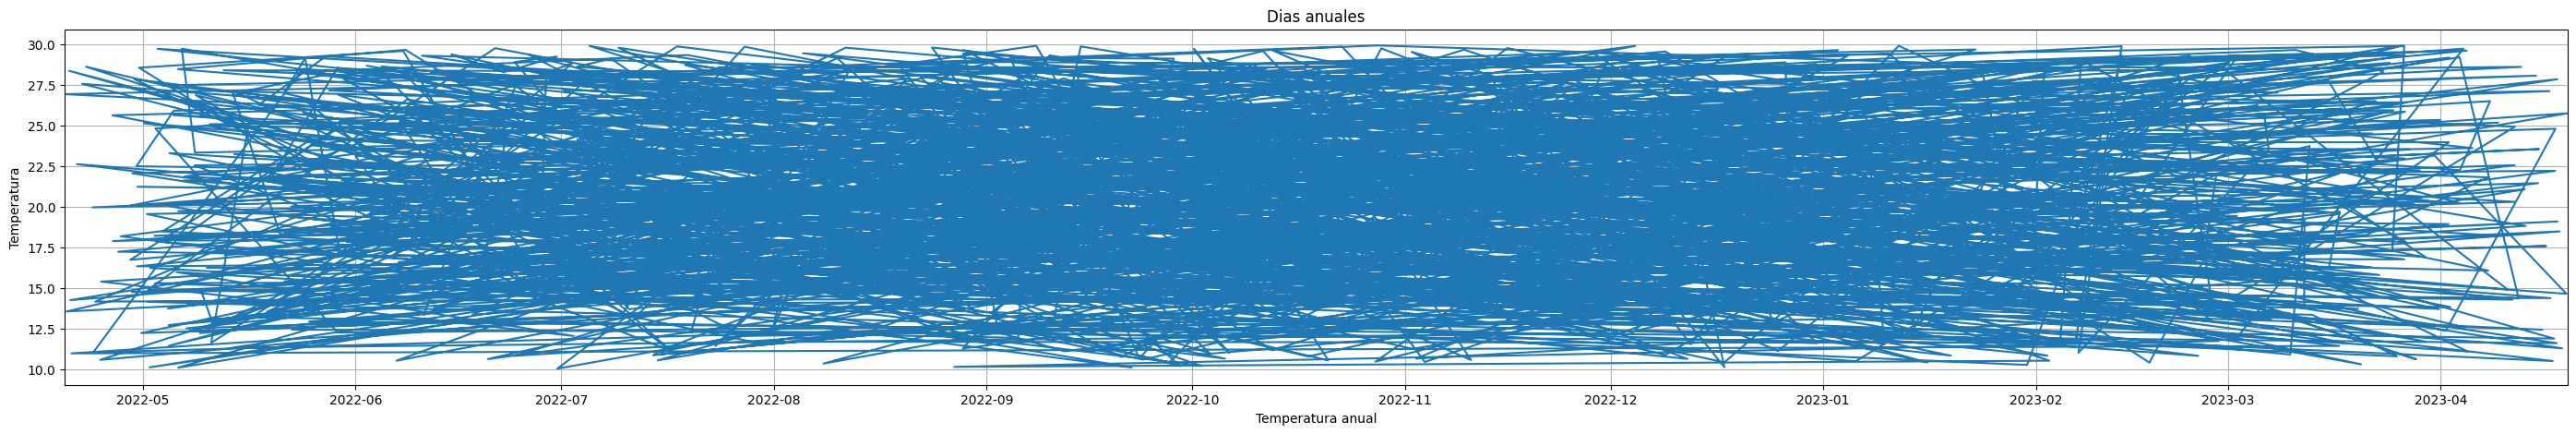

In [28]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 35
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Dias anuales')
plt.ylabel('Temperatura')
plt.xlabel('Temperatura anual')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['temperatura'])
plt.show()

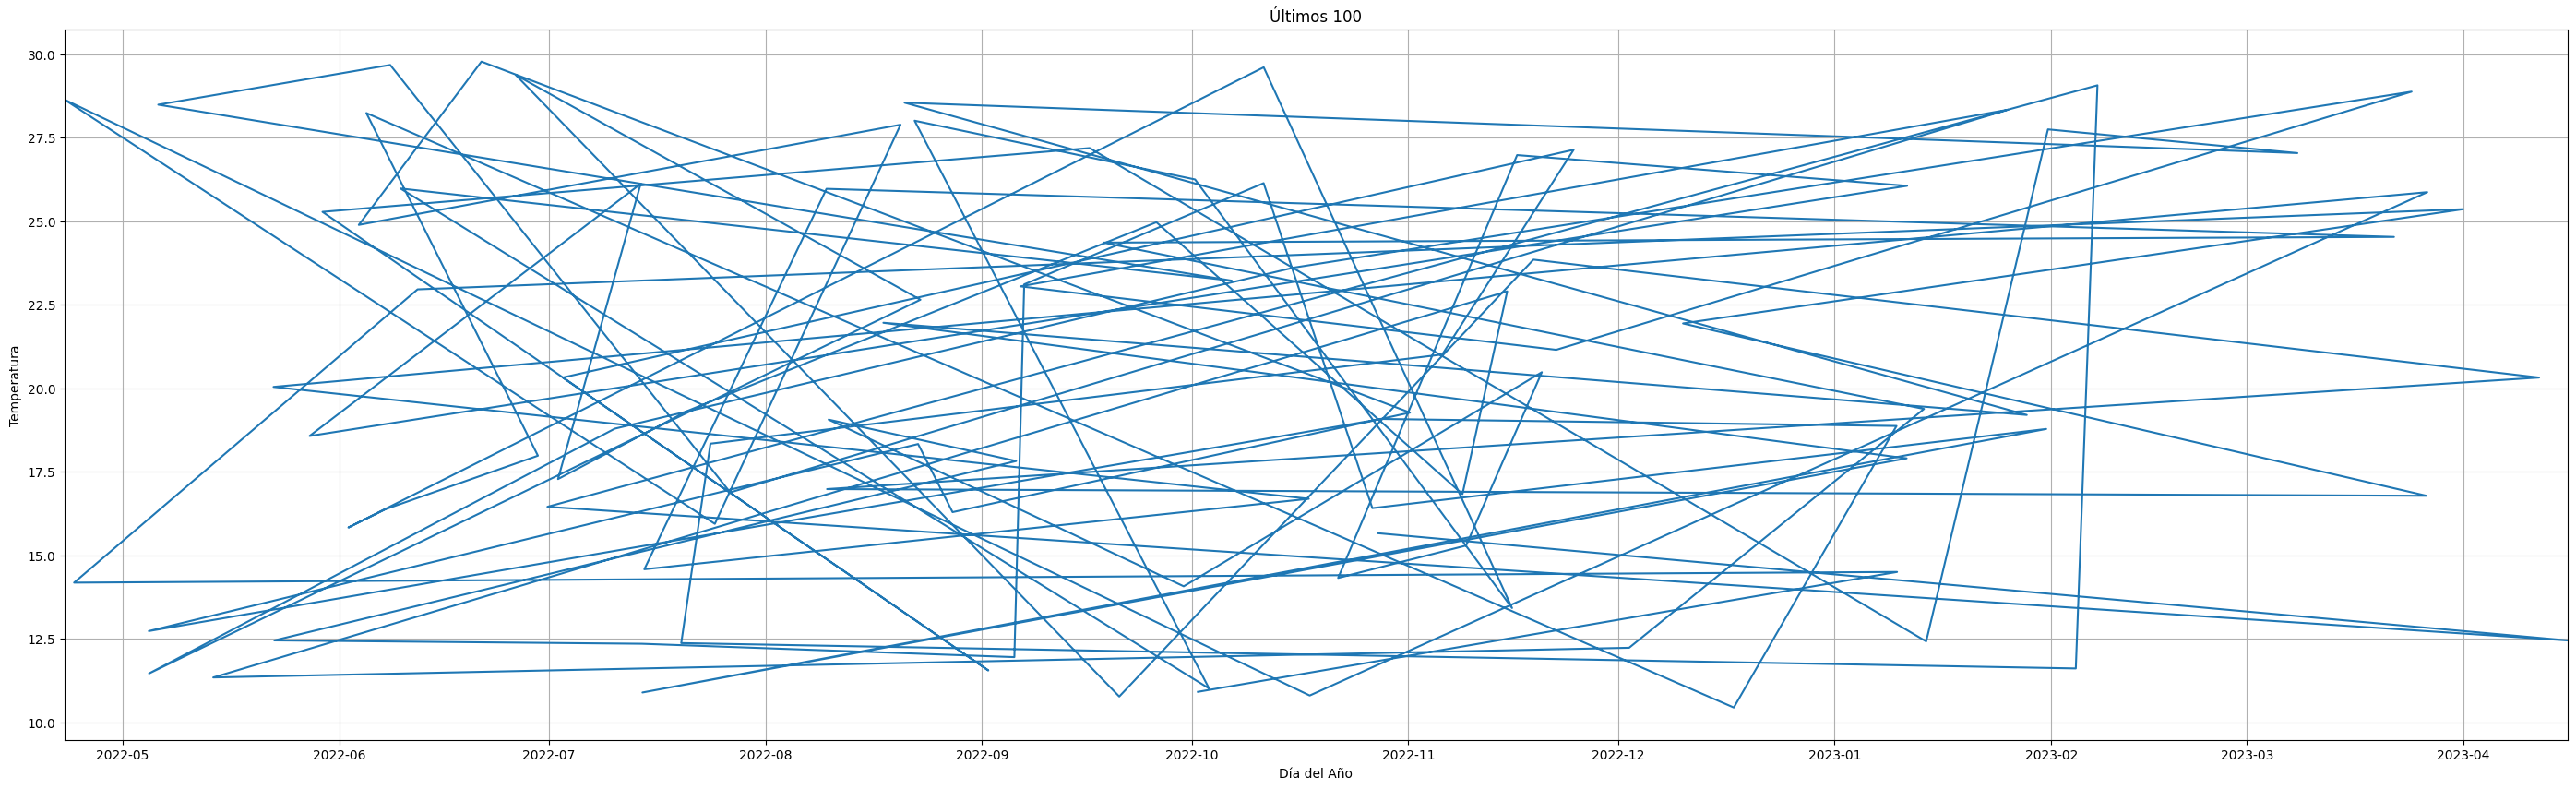

In [30]:
import matplotlib.pyplot as plt

# Establecer el tamaño de la figura
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 35
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

# Obtener los últimos 100 números de la columna 'Temperatura'
ultimos_100 = df['temperatura'][-100:]

# Crear el gráfico
plt.title('Últimos 100')
plt.ylabel('Temperatura')
plt.xlabel('Día del Año')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(ultimos_100)
plt.show()

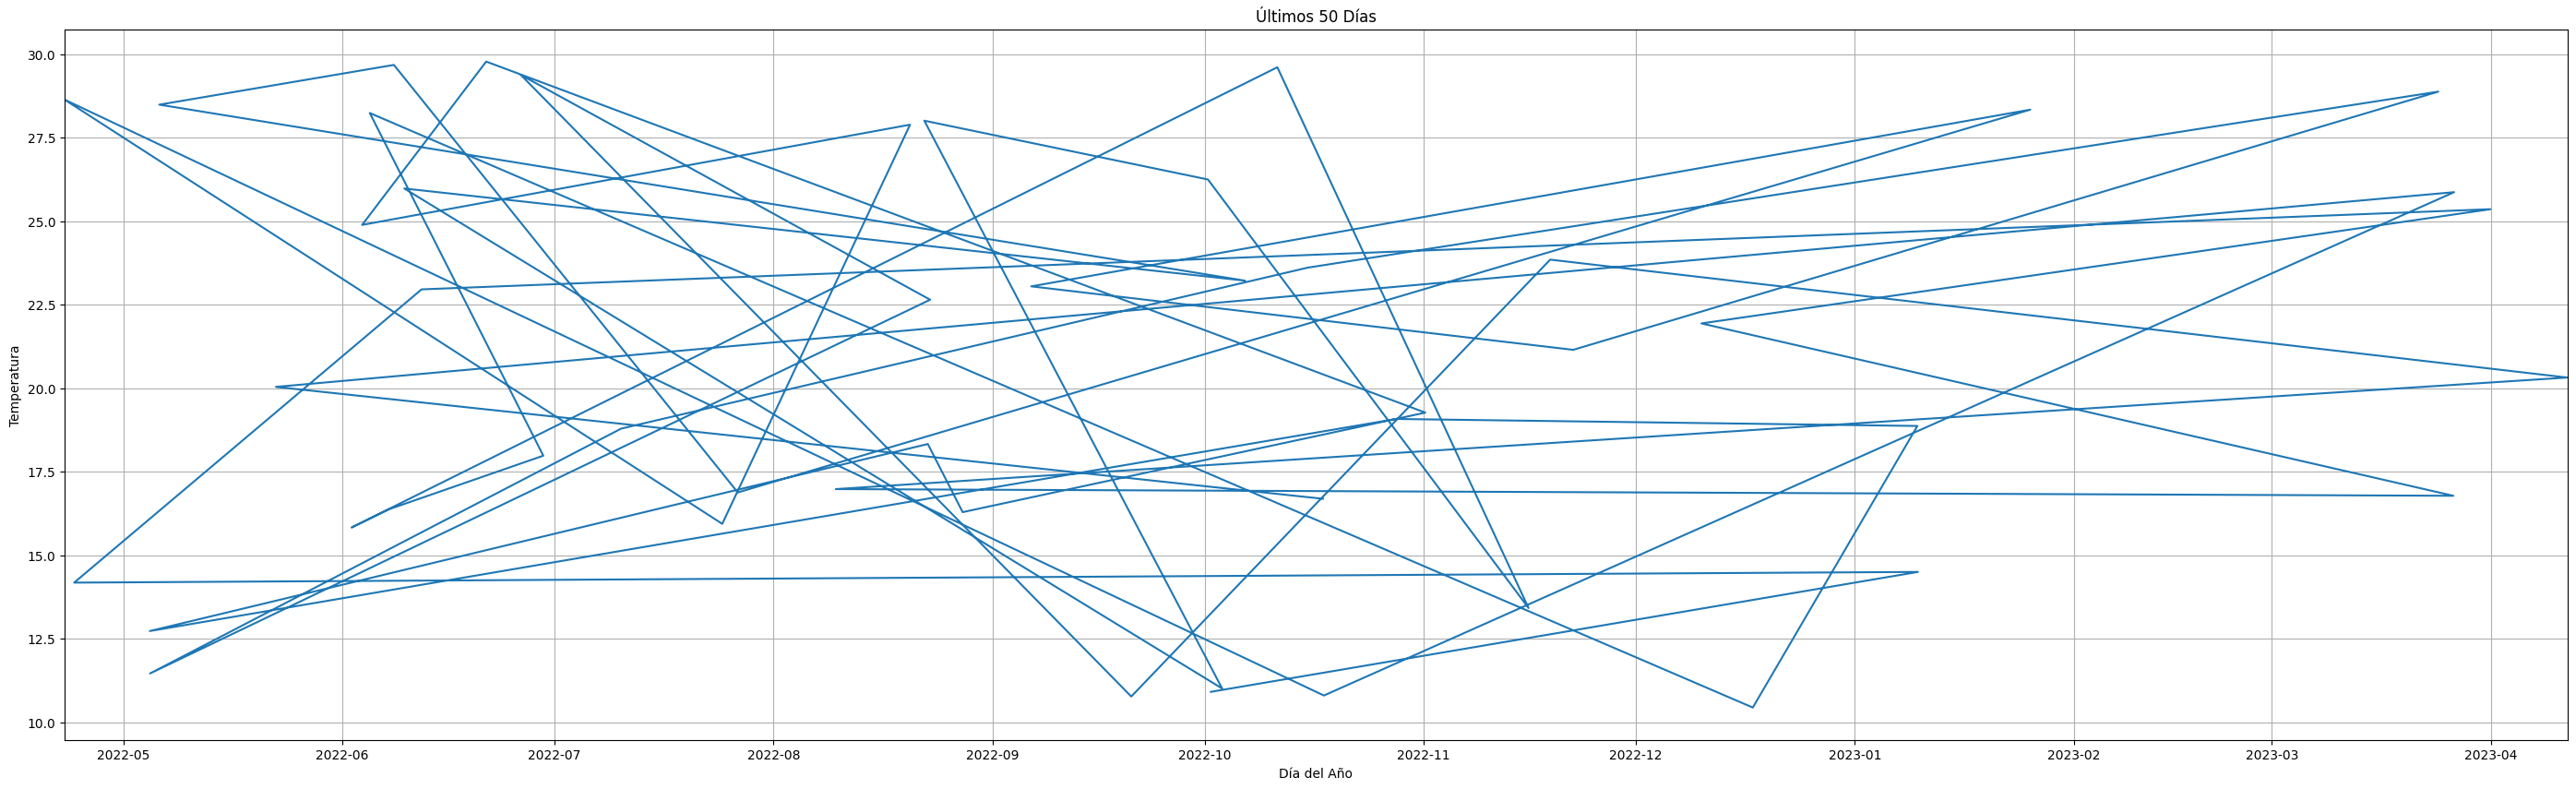

In [31]:
# Obtener los últimos 100 números de la columna 'Temperatura'
ultimos_50 = df['temperatura'][-50:]

# Crear el gráfico
plt.title('Últimos 50 Días')
plt.ylabel('Temperatura')
plt.xlabel('Día del Año')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(ultimos_50)
plt.show()

In [33]:
all_data = df['temperatura'].values.astype(float)

test_data_size = 50

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [34]:
train_data.shape, test_data.shape


((1045,), (50,))

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.33165829]
 [-0.27035176]
 [-0.17085427]
 [ 0.56582915]
 [ 0.73366834]]
[[-0.06231156]
 [ 0.43819095]
 [ 0.45527638]
 [ 0.6       ]
 [-0.54472362]]


In [36]:
train_data_normalized.shape

(1045, 1)

In [37]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized.shape

torch.Size([1045])

In [38]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [40]:
train_window = 12 # tamaño de la ventana de tiempo
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [41]:
class DeepRNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        # Definir una capa RNN con input_size entradas y hidden_layer_size salidas
        self.rnn = nn.RNN(input_size, hidden_layer_size)
        # Agregar una capa Dropout
        self.dropout = nn.Dropout(p=0.2)
        # Definir una capa lineal con hidden_layer_size entradas y output_size salidas
        self.linear = nn.Linear(hidden_layer_size, output_size)
        # Inicializar la capa oculta con un tensor de ceros
        self.hidden_cell = torch.zeros(1, 1, self.hidden_layer_size)
        
    def forward(self, input_seq):
        # Pasar la secuencia de entrada a través de la capa RNN
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # Agregar la capa Dropout
        dropout_out = self.dropout(rnn_out)
        # Pasar la salida de la capa RNN a través de la capa lineal para producir las predicciones
        predictions = self.linear(dropout_out.view(len(input_seq), -1))
        # Devolver la última predicción
        return predictions[-1]

In [42]:
model=DeepRNN()
model

DeepRNN(
  (rnn): RNN(1, 100)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [43]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [44]:
epochs = 50
# Ciclo de entrenamiento
for i in range(epochs + 1):
  # Ciclo de entrenamiento para cada secuencia de entrada
  for seq,label in train_inout_seq:
    # Reiniciar los gradientes
    optimizer.zero_grad()
    # Reiniciar el estado oculto de la red
    model.hidden_cell=(torch.zeros(1,1,model.hidden_layer_size))
    # Propagación hacia adelante a través de la red
    y_pred=model(seq)
    # Calcular la pérdida para la predicción actual
    single_loss=loss_function(y_pred,label)
    # Propagación hacia atrás de la pérdida
    single_loss.backward()
    # Actualizar los pesos de la red
    optimizer.step()
  # Imprimir la pérdida cada 5 épocas
  if i%25==0:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
# Imprimir la pérdida final
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.32242519
epoch:  25 loss: 0.15039261
epoch:  50 loss: 0.17554189
epoch:  50 loss: 0.1755418926


In [45]:
# Obtener los últimos datos de entrenamiento normalizados
test_inputs = train_data_normalized[-train_window:].tolist()

# Establecer el modelo en modo de evaluación
model.eval()

for i in range(test_data_size):
    # Crear una secuencia de entrada a partir de los últimos datos de prueba
    seq = torch.FloatTensor(test_inputs[-train_window:])
    # Desactivar el cálculo de gradientes para la predicción
    with torch.no_grad():
        # Establecer el estado oculto inicial en cero
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        # Realizar la predicción y agregarla a los datos de prueba
        test_inputs.append(model(seq).item())
        
# Invertir la normalización y obtener las predicciones reales
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

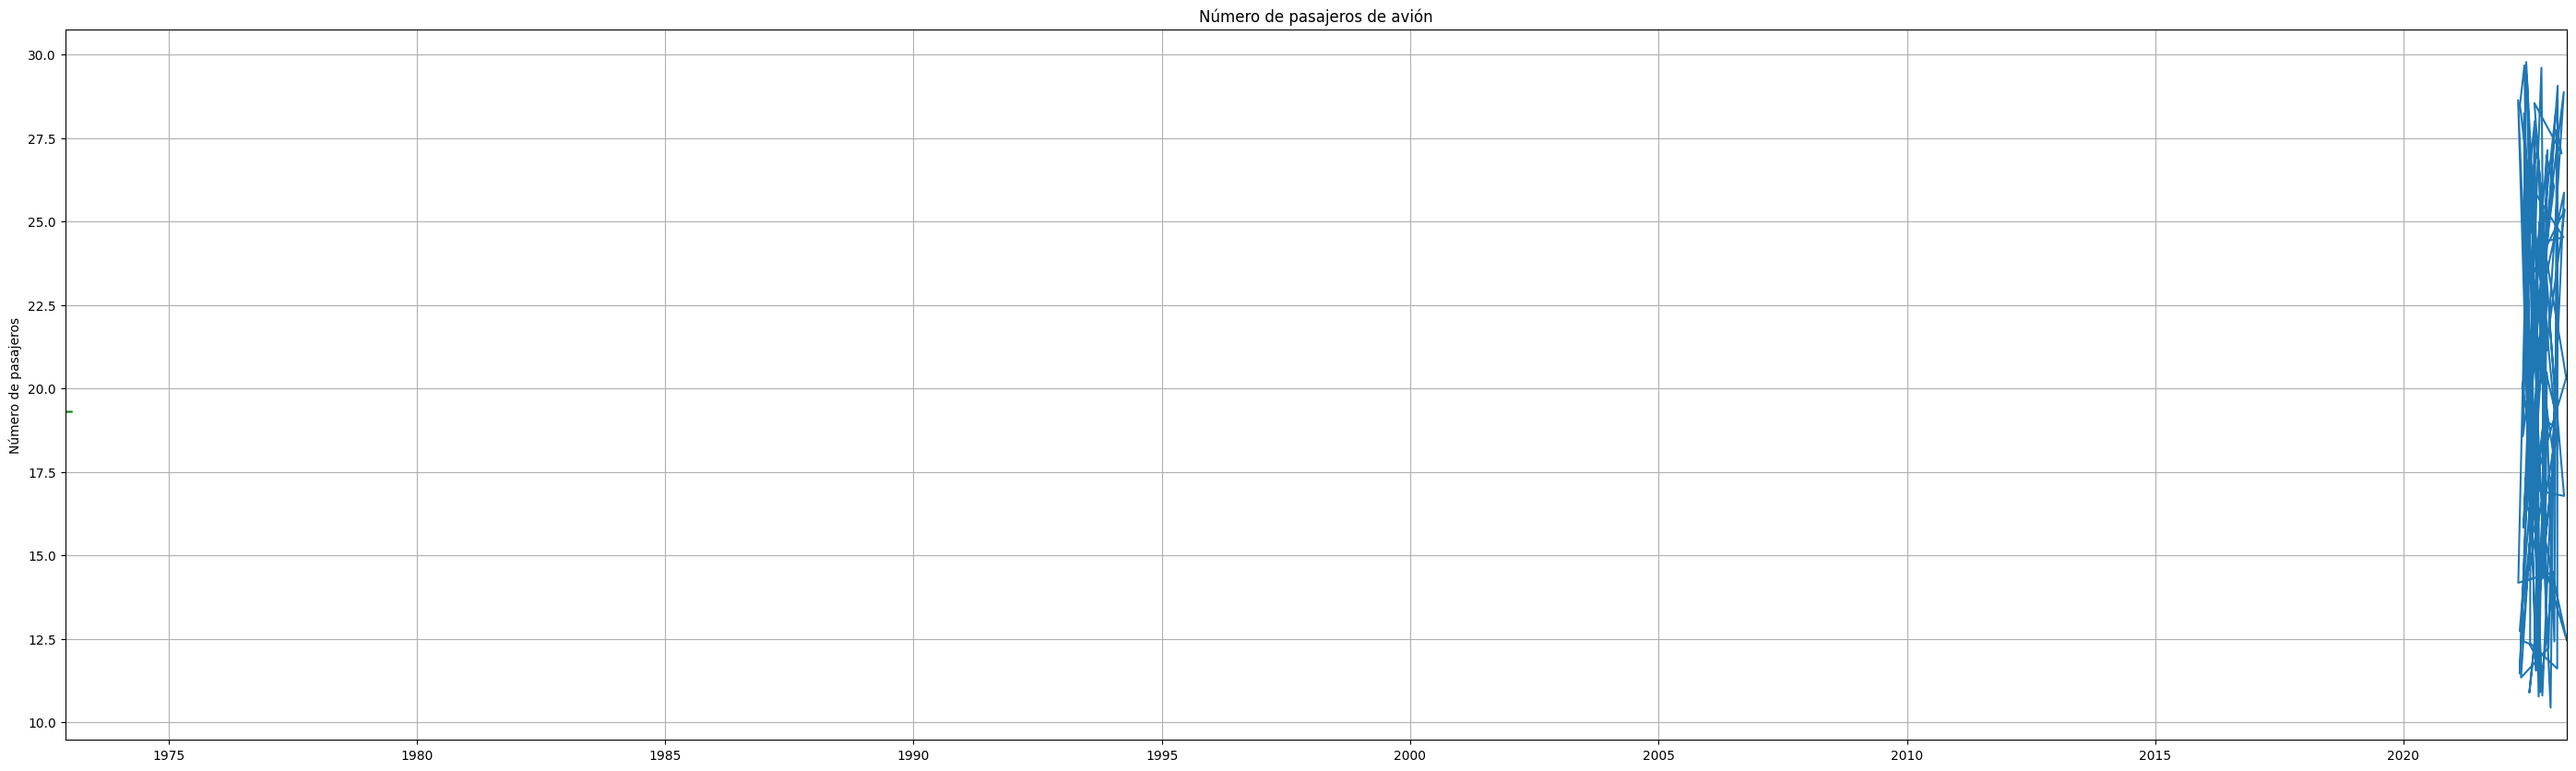

In [50]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1066, 1116, 1)
# estamos generando un rango de valores que comienza en 132 y termina en 144 con un intervalo de 1. 
# Esto significa que cada punto en el eje x representará un solo mes.
ultimos_100 = df['temperatura'][-100:]

plt.title("Número de pasajeros de avión")
plt.ylabel("Número de pasajeros")
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(ultimos_100)
plt.plot(x,actual_predictions, color='green')
plt.show()